<footer id="footer"></footer>

# <center> Проект для «Викишоп» с BERT </center> 

![](https://i.ibb.co/pjcBRMR/bbc87fcc-3bb9-422a-a925-60ae8f17b019.jpg)

Интернет-магазин **«Викишоп»** запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.  


Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.  

---
<font size="2">
Примечание

*Модель должна быть со значением метрики качества F1 не меньше 0.75*
</font>     



## Подготовка

### Загрузка необходимых библиотек

In [1]:
%%capture
!pip install transformers;

In [2]:
%%capture
!pip install wordcloud;

In [3]:
%%capture
!pip install tqdm;

In [4]:
%%capture
!pip install textwrap3;

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import re



import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from textwrap3 import wrap

import torch
import transformers
import logging
from wordcloud import WordCloud


import warnings
import seaborn as sns
from tqdm import notebook
from tqdm import tqdm
from pprint import pprint
from time import time

sns.set_style('darkgrid')
nltk.download('punkt')
nltk.download('wordnet')
warnings.filterwarnings('ignore', category=RuntimeWarning)
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

np.random.seed(42)

[nltk_data] Downloading package punkt to /Users/Arty/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Arty/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Arty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Загрузка данных и первичный осмотр

In [6]:
%%capture
! gdown --id 1QNQ79uPy6irNCA8hgNtDXtuc4ZPCzD0_;

In [7]:
try: 
    df = pd.read_csv('toxic_comments.csv')
except:
    df = pd.read_csv('/content/toxic_comments.csv')
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Столбец `text` содержит текст комментария, а `toxic` — целевой признак  

Проверим пропуски

In [8]:
df.isna().mean()

text     0.0
toxic    0.0
dtype: float64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Датасет содержит 159571 строку, типы данных соответствуют желаемым

In [10]:
df.duplicated().sum()

0

Для удобства приведем текст к нижнему регистру

In [11]:
df['text'] = df['text'].str.lower()

In [12]:
df.head()

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0


**Вывод:** Преобразования первичные сделали, проверили на пропуски и дубликаты

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

Создадим корпус, текст приведем к формату Unicode

In [13]:
corpus = df['text'].values.astype('U')

Нам необходимо преобразовать текст, получить леммы, а также очистить от линих символов. Преобразования сделаем через функцию и библиотеку `nltk` и `re`

In [14]:
def text_preprocessing(text):
    tokenized = nltk.word_tokenize(text)
    joined = ' '.join(tokenized)
    text_only = re.sub(r"[^a-z0-9!@#\$%\^\&\*_\-,\.' ]", ' ', joined)
    final = ' '.join(text_only.split())
    return final

In [15]:
tqdm.pandas() 
df['token_text'] = df['text'].progress_apply(text_preprocessing)

100%|██████████| 159571/159571 [01:38<00:00, 1623.41it/s]


Получили леммы слов, можно продолжить работу с сетом

In [16]:
df.head()

,text,toxic,token_text
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,d'aww! he matches this background colour i'm s...,0,d'aww ! he matches this background colour i 'm...
2,"hey man, i'm really not trying to edit war. it...",0,"hey man , i 'm really not trying to edit war ...."
3,"""\nmore\ni can't make any real suggestions on ...",0,more i ca n't make any real suggestions on imp...
4,"you, sir, are my hero. any chance you remember...",0,"you , sir , are my hero . any chance you remem..."


Также преобразуем признак `token_text` к формату Unicode

In [17]:
corpus_lemm = df['token_text'].values.astype('U')

Получили корпус для дальнейшей обработки

In [18]:
corpus_lemm_toxic = df['token_text'][df['toxic'] == 1].values.astype('U')

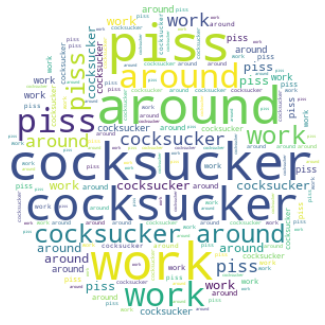

In [19]:
x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 150 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color="white", 
               random_state=42, mask=mask, repeat=True,
               stopwords=stopwords).generate(corpus_lemm_toxic[0])

plt.figure(figsize=(15, 10), dpi=42)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

**Вывод:** Преобразовали датасет и получили леммы слов. В облаке слов чаще всего встречаются слова **cocksucker, piss** - попробуем обучить модели для предсказания токсичности текста. 

Учить будем ансамбль моделей на базе Логистической регрессии, Случайного леса и SGD классификатора, попробуем обучить отдельно SGD классификатор, а таже воспользуемся Word2vec классом моделей BERT для получения эммбендингов и предсказания на них - возможно нам удастся улучшить результаты базовых моделей

Для ускорения процесса обучения BERT будет передаваться лишь часть датасета, что должно определнным образом сказаться на результате

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

## Обучение моделей

Выведем наш датасет еще раз и посмотрим на распределение классов

In [20]:
df.head()

,text,toxic,token_text
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,d'aww! he matches this background colour i'm s...,0,d'aww ! he matches this background colour i 'm...
2,"hey man, i'm really not trying to edit war. it...",0,"hey man , i 'm really not trying to edit war ...."
3,"""\nmore\ni can't make any real suggestions on ...",0,more i ca n't make any real suggestions on imp...
4,"you, sir, are my hero. any chance you remember...",0,"you , sir , are my hero . any chance you remem..."


In [21]:
df['toxic'].value_counts(normalize=True).to_frame()

,toxic
0,0.898321
1,0.101679


Токсичных комментариев в нашем сете всего 10%, наблюдается сильный дисбаланс классов. Попробуем пойти двумя путями:

- обучим модель на сете с применением **downsampling**
- обучим модель с выставлением параметра **class_weight='balanced'**

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Подготовка признаков

Выделим из дата сета целевой признак и обучающий признак - текст

In [22]:
features = df['token_text']
target = df['toxic']

Разделим нашу выборку, размер теста обозначим как 25%

In [23]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42)

Напишем функцию, пощволяющую достичь баланса класс, через downsampling

In [24]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_sample = features_zeros.sample(frac=0.1, random_state=42)
    target_sample = target_zeros.sample(frac=0.1, random_state=42)
    
    features_downsampled = pd.concat([features_sample] + [features_ones])
    target_downsampled = pd.concat([target_sample] + [target_ones])
    
    features_downsampled = shuffle(features_downsampled, random_state=42)
    target_downsampled = shuffle(target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

Получим новые сеты

In [25]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

print(features_downsampled.shape)
print(target_downsampled.shape)

(22917,)
(22917,)


In [26]:
target_downsampled.value_counts(normalize=True)

1    0.530872
0    0.469128
Name: toxic, dtype: float64

Дисбаланс незначительный, с таким сетом можно попробовать обучить модель. Для начала получим TD-IDF меру для нового сета

In [27]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf = count_tf_idf.fit_transform(features_downsampled)

print("Размер матрицы обучения:", tf_idf.shape)

Размер матрицы обучения: (22917, 52572)


In [28]:
model_name = []
fscore = []

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Обучение ансамбля Логистической регрессии, Случайного леса и SGD моделей c downsampling

Обучим ансамбль моделей с применением техники downsampling

In [29]:
X_train_ans = tf_idf
y_train_ans = target_downsampled

In [30]:
%%time
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
sgb_clf = SGDClassifier(max_iter = 1000, random_state=42, loss='modified_huber')

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('sgb', sgb_clf)],
    voting='soft')

X_test_ans = count_tf_idf.transform(features_test)

voting_clf.fit(X_train_ans, y_train_ans)
predict = voting_clf.predict(X_test_ans)
f_score = f1_score(predict, target_test)

print('{}'.format(f_score))

0.6525618618342379
CPU times: user 5.45 s, sys: 3.67 s, total: 9.13 s
Wall time: 4.97 s


F1 мера ниже проходной 0.75, модель плохо обобщается на тесте - попробуем обучение без downsampling с балансом классов

In [31]:
model_name.append(str(voting_clf.__class__.__name__)+str(' ')+str('downsampling LR, RF, SGD'))
fscore.append(round(f_score, 2))

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Обучение ансамбля Логистической регрессии, Случайного леса и SGD моделей  без downsampling

Обучим модель на базе того же ансамбля, но вместо сбалансированного сета используем базовый лемматизированный и вес классов установим как сбалансированный

In [32]:
count_tf = TfidfVectorizer(stop_words=stopwords)
tf_idf_new = count_tf.fit_transform(features_train)

Получили TD IDF для нашей обучающей выборки. Составим ансмабль моделей

In [33]:
%%time
X_train = tf_idf_new
y_train = target_train

X_test = count_tf.transform(features_test)


log_clf = LogisticRegression(solver="liblinear", random_state=42,
                            class_weight='balanced')
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, 
                            class_weight='balanced')
sgb_clf = SGDClassifier(max_iter = 1000, random_state=42, 
                        loss='modified_huber')

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('sgb', sgb_clf)],
    voting='soft')

voting_clf.fit(X_train, y_train)
predict_new = voting_clf.predict(X_test)

CPU times: user 4min 59s, sys: 13.9 s, total: 5min 13s
Wall time: 4min 58s


In [34]:
f_score = f1_score(predict_new, target_test)
print(f_score)

0.7879455070868308


С таким подходом удалось увеличить F1 меру до проходной

In [35]:
(model_name.append(str(voting_clf.__class__.__name__)
                   +str(' ')
                   +str('class_weight balanced, LR, RF, SGD')))
fscore.append(round(f_score, 2))

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Обучение модели SGD без downsampling c GS и Pipeline

Попробуем модель с стохастическим градиентным спуском отдельно, без downsampling с использованием CountVectorizer и TfidfTransformer через Pipeline

In [36]:
X_train = features_train
y_train = target_train

In [37]:
%%capture
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
# подготовим Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(class_weight='balanced',
                         early_stopping=True, loss='modified_huber')),
])

# соберем словарь параметров для GS_CV

parameters = {

    'vect__max_features': (50000, 60000),
    'tfidf__use_idf': (True, False),
    'clf__alpha': (0.0001, 0.0001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (1000, 750),
}

# проведем поиск лучших параметров и обучим лучшую модель

grid_search = GridSearchCV(pipeline, parameters, verbose=100,
                          cv=5, scoring='f1')

print("Выполнение grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("параметры:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train, y_train)
print("сделано за %0.3fs" % (time() - t0))
print()

print("лучший score: %0.3f" % grid_search.best_score_)
print("лучшие параметры:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))



In [38]:
sgb_clf_gv = grid_search.best_estimator_

In [39]:
%%time

predict = sgb_clf_gv.predict(features_test)
f_score = f1_score(predict, target_test)
print(f_score)

0.736645576185043
CPU times: user 1.71 s, sys: 145 ms, total: 1.86 s
Wall time: 1.71 s


Результат неудовлетворительный, стоит отметит, что скорость обучения такаже достаточно низкая

In [40]:
model_name.append(str(sgb_clf.__class__.__name__)+str(' ')+str('class_weight balanced'))
fscore.append(round(f_score, 2))

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Ансамбль на базе Случайного леса, Особо случайного леса, Опорных векторов и MLPClassifier

Создадим валидационную выборку для отсройки модели и обучающую

In [41]:
X_train, X_val, y_train, y_val = train_test_split(
    features_train, target_train, test_size=0.2, random_state=42)

In [42]:
count_tf = TfidfVectorizer(stop_words=stopwords)
X_train_idf = count_tf.fit_transform(X_train)
X_val_idf = count_tf.transform(X_val)
X_test = count_tf.transform(features_test)

Создадим модели на базе RandomForestClassifier, ExtraTreesClassifier, LinearSVC, MLPClassifier и проверим их производительность по отдельности - если результаты будут схожими - составим из них ансамбль

In [43]:
random_forest_clf = RandomForestClassifier(n_estimators=10, random_state=42, 
                                           class_weight='balanced')
extra_trees_clf = ExtraTreesClassifier(n_estimators=10, random_state=42, 
                                       class_weight='balanced')
svm_clf = LinearSVC(random_state=42, class_weight='balanced')
mlp_clf = MLPClassifier(random_state=42, early_stopping=True)

In [44]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print('Обучение', estimator)
    estimator.fit(X_train_idf, y_train)

Обучение RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)
Обучение ExtraTreesClassifier(bootstrap=False, class_weight='balanced', criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)
Обучени

Посмотрим производительность наших моделей на валидационной выборке

In [45]:
[estimator.score(X_val_idf, y_val) for estimator in estimators]

[0.9350350935828877,
 0.9347008689839572,
 0.9488218582887701,
 0.9553810160427807]

Результаты достаточно хорошие на всех моделях - соберем из них ансамбль с мягким голосованием

In [46]:
estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [47]:
voting_clf = VotingClassifier(estimators, voting = "soft")

In [48]:
voting_clf.fit(X_train_idf, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight='balanced',
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=10,
                                                     n_j

In [51]:
del voting_clf.estimators_[2]

In [52]:
voting_clf.estimators_

[RandomForestClassifier(bootstrap=True, class_weight='balanced',
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=10, n_jobs=None, oob_score=False,
                        random_state=42, verbose=0, warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight='balanced', criterion='gini',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False),
 MLPClass

In [53]:
%%time

predict = voting_clf.predict(X_test)
f_score = f1_score(predict, target_test)
print(f_score)

0.7386882829771555
CPU times: user 1.13 s, sys: 104 ms, total: 1.24 s
Wall time: 1.19 s


Результат неудовлетворительный, стоит отметит, что скорость обучения такаже достаточно низкая

In [54]:
model_name.append(str(voting_clf.__class__.__name__)+str(' ')+str('RF, ERF, LSVC, MLP'))
fscore.append(round(f_score, 2))

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Обучение модели BERT (DistilBertModel)

Для обучения модели с предподготовкой с помощью BERT построим новый сет, сбалансированный, так как нам придется передавать на порядок меньше строк для обучения, что является не совсем адекватной оценкой производительности

Создадим выборки для BERT и уберем дисбаланс классов в обучающей выборке. Тестовую выборку отложим и трогать не будем

In [55]:
features = df['text']
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42)

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

target_downsampled.value_counts(normalize=True).to_frame()

,toxic
1,0.530872
0,0.469128


Создадим сет из обучабщей сбалансированной выборки, из него удалим дубликаты и возьмем образец в 500 значений

In [56]:
df_bert = features_downsampled.to_frame().join(
    target_downsampled.to_frame())
df_bert.head()

,text,toxic
118312,anybody that has dived the devil's throat plea...,0
9946,"""\ngoal of operation tko\n""""the original goal ...",0
62211,"better just that she-dog. here girl, here gir...",1
128078,i'd rather not revert you any further. tell me...,1
144243,"""\n\n rutherford b. hayes edits \n\n""""please r...",1


In [57]:
df_bert.duplicated().sum()

9

In [58]:
df_bert.drop_duplicates(inplace=True)
df_bert.duplicated().sum()

0

In [59]:
df_bert[df_bert.index == 118312]

,text,toxic
118312,anybody that has dived the devil's throat plea...,0


Таким образом получили новый сет, из которого будем брать срезы, при этом удалили все дубликаты, проверили один индекс для того, чтобы удостовериться, что сет собрался адекватно

In [60]:
df_comm = df_bert.sample(500).reset_index(
    drop=True)
df_comm.head()

,text,toxic
0,"""""""casual relationship"""" is far too nonspecifi...",1
1,"""\n\nchicken-ryu?\nall the ip addresses you us...",0
2,"categorization\ncorrect me if i'm wrong, but i...",0
3,yea yea yea you fucking dunce. since the first...,1
4,"""\n\nplease, have | has any of you heard the ""...",0


In [61]:
df_comm['toxic'].value_counts(normalize=True).to_frame()

,toxic
1,0.548
0,0.452


Получили достаточно сбалансированную выборку.  

Преобразуем наши признаки с целью получения эммбендингов

In [62]:
configuration = transformers.DistilBertConfig()
model = transformers.DistilBertModel(configuration)
pretrained_weights = 'distilbert-base-uncased'
tokenizer_class = transformers.DistilBertTokenizer

Стоит отметить, что модель обучена для работы с предложениями до 512 символов. Необходим обрезать наши предложения, если они превышают данный лимит. Это также модет сказаться на результатах

In [63]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

tokenized = df_comm['text'].apply(
    lambda x: tokenizer.encode(x[:512], add_special_tokens=True))

padded = np.array([i + [0]*(512 - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [64]:
len(padded[0])

512

In [65]:
padded.shape, attention_mask.shape

((500, 512), (500, 512))

In [66]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/5 [00:00<?, ?it/s]

Создаим обучающий и целевой наборы данных для нашей модели

In [67]:
X_train = np.concatenate(embeddings)
y_train = df_comm['toxic'][:padded.shape[0]]

Проверим визуально правильно ли отобрались целевые классы

In [68]:
y_train.values[:50]

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1])

In [69]:
df_comm['toxic'].values[:50]

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1])

Проверим сеты на форму

In [70]:
X_train.shape, y_train.shape

((500, 768), (500,))

In [71]:
y_train.value_counts(normalize=True).to_frame()

,toxic
1,0.548
0,0.452


Целевой признак сбалансирован на обучающей выборке

Подготовим тестовую выборку. Возьмем 200 случайных значений и получим эмбенддинги для теста

In [72]:
test = features_test.to_frame().join(
    target_test.to_frame()).sample(200).reset_index(
    drop=True)
test.head()

,text,toxic
0,edinburgh one of europe's main financial cente...,0
1,"""\n fascinating. well, thank you for your tim...",0
2,"katr67, i apologize if that came across as unc...",0
3,no. this decision is not democratic and is out...,0
4,thanks for the update. the work you are doing ...,0


In [73]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

tokenized = test['text'].apply(
    lambda x: tokenizer.encode(x[:512], add_special_tokens=True))

padded = np.array([i + [0]*(512 - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [74]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/2 [00:00<?, ?it/s]

In [75]:
X_test = np.concatenate(embeddings)
y_test = test['toxic'][:X_test.shape[0]]

In [76]:
y_test.value_counts(normalize=True).to_frame()

,toxic
0,0.905
1,0.095


В тестовой выборке наблюдается дисбаланс классов. Обучим модель ансамбль с MLP из пункта 2.5

In [77]:
%%time
voting_clf.fit(X_train, y_train)

CPU times: user 884 ms, sys: 556 ms, total: 1.44 s
Wall time: 623 ms


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight='balanced',
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=10,
                                                     n_j

In [79]:
del voting_clf.estimators_[2]

In [80]:
predict = voting_clf.predict(X_test)

In [81]:
f_score = f1_score(predict, y_test)
print(f_score)

0.21359223300970875


К сожалению мы получили достаточно низкий результат. Но данный факт связан с тем, что с целью уменьшения времени обучения нам пришлось передавать не весь сет на обучение, и нам пришлось обрезать предложения, что модель могла с ними работать, что могло повлиять на контекст

In [82]:
model_name.append(str(voting_clf.__class__.__name__)+str(' ')+str('BERT_MLP'))
fscore.append(round(f_score, 2))

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Проверка на адекватность (sanity check)

Построим константную модель. Она будет везде предсказывать 1 - токсиный комментарий, так как наша цель - выявлять именно их

In [83]:
dummy = DummyClassifier(random_state=42, strategy='constant', constant=1)

In [84]:
dummy.fit(features_train, target_train)
dummy_pred = dummy.predict(features_test)

In [85]:
f1_const = f1_score(target_test, dummy_pred)

print("Константа:", f1_const)

Константа: 0.1847014925373134


In [86]:
model_name.append(str(dummy.__class__.__name__)+str(' ')+str('constant 1'))
fscore.append(round(f1_const, 2))

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

## Выводы

In [87]:
summary = pd.DataFrame(
    { 'model' : model_name , 'F1' : fscore }
    ).reset_index( drop = True ).sort_values(by='F1', ascending=False)
summary['approved'] = summary['F1'].apply(lambda x: 'yes' if x >= 0.75 else 'not')
summary.style.highlight_max( 'F1' , color = 'green' , axis = 0 )


,model,F1,approved
1,"VotingClassifier class_weight balanced, LR, RF, SGD",0.79,yes
2,SGDClassifier class_weight balanced,0.74,not
3,"VotingClassifier RF, ERF, LSVC, MLP",0.74,not
0,"VotingClassifier downsampling LR, RF, SGD",0.65,not
4,VotingClassifier BERT_MLP,0.21,not
5,DummyClassifier constant 1,0.18,not


Таким образом, приемлемые результаты получили на ансамбле моделей Логистической регрессии, случайного леса и SGD - он адекватно соотносятся и со временем работы и с качеством F1 меры. Ансамбль с MLP на базе BERT для классификации длинных текстов, таких как комментарии для данных целей не стоит - приходится обрезать текст, что может повлиять на контекст, приходится ограничивать количество данных для обучения и предсказания. 


Считаю, что для данных целей лучшая модель - основанная на ансамбле моделей на базе Логистической регрессии, SGDклассификаторе с l2 регуляризацией и Случайным лесом с установленным параметром весов классов - как 'balanced'

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


---
<font size="1">
ArtyKraftyy
</font>     
